In [64]:
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.optimize import minimize
import pandas as pd
import patsy as pt
import scipy.stats as st
import matplotlib.pyplot as plt

In [65]:
df = pd.read_csv("https://raw.githubusercontent.com/roualdes/data/refs/heads/master/penguins.csv")
df.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
3          NaN     NaN  2007  
4       3450.0  female  2007

In [66]:
dfu = df.dropna(subset = ["sex", "body_mass_g"])

In [67]:
dfg = dfu.groupby("sex").aggregate(mn_mass = ("body_mass_g", np.mean))
dfg["mn_mass"].values
# N = np.size(dfg["mn_mass"].values) # wrong

array([3862.27272727, 4545.68452381])

In [68]:
N = np.shape(dfu)[0] # right
R = 1_000
mns = np.zeros(shape = (R, 2))
rng = np.random.default_rng()
for r in range(R):
    idx = rng.integers(N, size = N)
    dfg = dfu.iloc[idx, :].groupby("sex").aggregate(mn_mass = ("body_mass_g", np.mean))
    mns[r] = dfg["mn_mass"].values

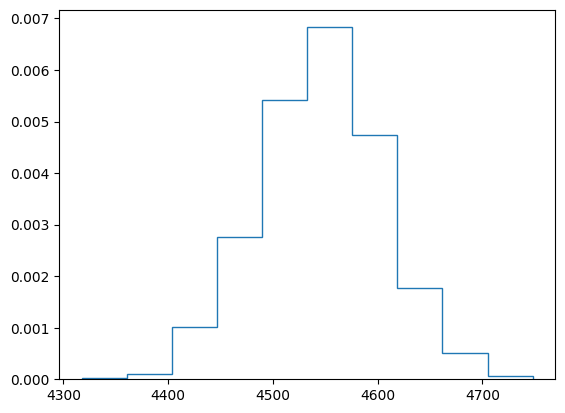

In [69]:
plt.hist(mns[:, 1], density = True, histtype = "step");

In [70]:
np.quantile(mns[:, 0], (0.025, 0.975))

array([3760.07521969, 3957.47917025])

In [71]:
np.quantile(mns[:, 1], (0.025, 0.975))

array([4429.63978293, 4660.6533419 ])

In [72]:
dfu.columns

Index(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex', 'year'],
      dtype='object')

In [73]:
y, X = pt.dmatrices("body_mass_g ~ species", data = dfu)

In [74]:
def lm(theta, X):
    N = np.shape(X)[0]
    lm = np.zeros(N)
    for n in range(N):
        lm[n] = np.sum(theta * X[n, :])
    return lm

In [75]:
def mse(y, yhat):
    d = y - yhat
    return np.mean(d * d)

In [76]:
def normal_ll(theta, data):
    y = data["y"]
    X = data["X"]
    yhat = lm(theta, X)
    return mse(y, yhat)

In [77]:
rng = np.random.default_rng()
o = minimize(normal_ll, rng.normal(size = 3), args = ({"y": y[:, 0], "X": X},))
beta = o.x

In [78]:
N = np.shape(dfu)[0] # right
R = 1_000
mns = np.zeros(shape = (R, 3))
rng = np.random.default_rng()
for r in range(R):
    idx = rng.integers(N, size = N)
    o = minimize(normal_ll, rng.normal(size = 3), args = ({"y": y[idx, 0], "X": X[idx,:]},))
    mns[r] = o.x

In [79]:
np.quantile(mns[:, 0], (0.025, 0.975)) # 95% CI for body mass (in grams) of Adelie penguins

array([3629.7150983 , 3776.58654731])

In [81]:
np.quantile(mns[:, 0] + mns[:, 2], (0.025, 0.975)) # # 95% CI for body mass (in grams) of Gentoo penguins

array([5008.72315642, 5181.2607565 ])